In [1]:
!pip install -q datasets torch scikit-learn
!pip install transformers==4.35.2 accelerate==0.25.0 evaluate

In [1]:
from datasets import load_dataset

dataset = load_dataset("glue", "stsb")
dataset

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 5749
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1500
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1379
    })
})

In [2]:
dataset["validation"][0]

{'sentence1': 'A man with a hard hat is dancing.',
 'sentence2': 'A man wearing a hard hat is dancing.',
 'label': 5.0,
 'idx': 0}

In [3]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel
import torch

model_name = "sentence-transformers/all-MiniLM-L6-v2"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    num_labels=1,
    problem_type="regression"
)
auto_model = AutoModel.from_pretrained(model_name)

model.eval()
auto_model.eval()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/huggingface_hub/file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
W0101 21:53:40.079000 13288 site-packages/torch/distributed/elastic/multiprocessing/redirects.p

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 384, padding_idx=0)
    (position_embeddings): Embedding(512, 384)
    (token_type_embeddings): Embedding(2, 384)
    (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-5): 6 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=384, out_features=384, bias=True)
            (key): Linear(in_features=384, out_features=384, bias=True)
            (value): Linear(in_features=384, out_features=384, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=384, out_features=384, bias=True)
            (LayerNorm): LayerNorm((384,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
    

In [4]:
def tokenize_function(examples):
    return tokenizer(
        examples["sentence1"],
        examples["sentence2"],
        padding="max_length",
        truncation=True,
        max_length=128
    )

In [5]:
def embed_sentences(sentences):
    with torch.no_grad():
        inputs = tokenizer(
            sentences,
            padding=True,
            truncation=True,
            return_tensors="pt"
        )
        outputs = auto_model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

In [6]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

def predict_similarity(batch):
    batch
    emb1 = embed_sentences(batch["sentence1"])
    emb2 = embed_sentences(batch["sentence2"])
    sims = cosine_similarity(emb1, emb2)
    return np.diag(sims)

In [7]:
sentences1 = list(dataset["validation"]["sentence1"])
sentences2 = list(dataset["validation"]["sentence2"])
labels = list(dataset["validation"]["label"])

type(sentences1), type(sentences1[0])

predictions = predict_similarity({
    "sentence1": sentences1,
    "sentence2": sentences2
})

predictions

array([0.99344677, 0.95968753, 0.9762485 , ..., 0.6700321 , 0.59020466,
       0.57838273], shape=(1500,), dtype=float32)

In [8]:
from scipy.stats import pearsonr

pearson_corr, p_value = pearsonr(predictions, labels)

pearson_corr, p_value

(np.float64(0.7947377617616544), np.float64(0.0))

In [9]:
for i in range(5):
    print("Sentence 1:", sentences1[i])
    print("Sentence 2:", sentences2[i])
    print("Gold:", labels[i])
    print("Pred:", round(predictions[i], 3))
    print("-" * 50)

Sentence 1: A man with a hard hat is dancing.
Sentence 2: A man wearing a hard hat is dancing.
Gold: 5.0
Pred: 0.993
--------------------------------------------------
Sentence 1: A young child is riding a horse.
Sentence 2: A child is riding a horse.
Gold: 4.75
Pred: 0.96
--------------------------------------------------
Sentence 1: A man is feeding a mouse to a snake.
Sentence 2: The man is feeding a mouse to the snake.
Gold: 5.0
Pred: 0.976
--------------------------------------------------
Sentence 1: A woman is playing the guitar.
Sentence 2: A man is playing guitar.
Gold: 2.4000000953674316
Pred: 0.764
--------------------------------------------------
Sentence 1: A woman is playing the flute.
Sentence 2: A man is playing a flute.
Gold: 2.75
Pred: 0.808
--------------------------------------------------


In [10]:
tokenized_dataset = dataset.map(tokenize_function, batched=True)

In [11]:
tokenized_dataset = tokenized_dataset.remove_columns(
    ["sentence1", "sentence2", "idx"]
)

tokenized_dataset = tokenized_dataset.rename_column("label", "labels")
tokenized_dataset.set_format("torch")

In [12]:
import evaluate

pearson_metric = evaluate.load("pearsonr")

def compute_metrics(eval_pred):
    preds = eval_pred.predictions
    labels = eval_pred.label_ids

    preds = preds.reshape(-1).astype("float32")
    labels = labels.reshape(-1).astype("float32")

    return pearson_metric.compute(
        predictions=preds,
        references=labels
    )

In [13]:
import transformers
transformers.__version__

'4.35.2'

In [14]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./stsb",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="pearsonr",
    greater_is_better=True,
    logging_steps=100
)

In [15]:
from transformers import Trainer

tokenized_dataset = tokenized_dataset.map(
    lambda x: {"labels": x["labels"].float()}
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [16]:
import torch

labels = torch.tensor(tokenized_dataset["train"]["labels"])
labels.dtype

torch.float32

In [17]:
sample = tokenized_dataset["train"][0]["labels"]
sample, type(sample), sample.dtype

(tensor(5.), torch.Tensor, torch.float32)

In [18]:
trainer.train()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Pearsonr
1,0.985000,0.748367,0.818188
2,0.679000,0.866310,0.828700
3,0.539200,0.777296,0.840720
4,0.442600,0.756083,0.848446
5,0.426400,0.704039,0.849129


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be 

TrainOutput(global_step=1800, training_loss=0.8468185530768501, metrics={'train_runtime': 260.8381, 'train_samples_per_second': 110.202, 'train_steps_per_second': 6.901, 'total_flos': 238329300376320.0, 'train_loss': 0.8468185530768501, 'epoch': 5.0})

In [19]:
trainer.evaluate()

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.7040387988090515,
 'eval_pearsonr': 0.8491292675814204,
 'eval_runtime': 4.0623,
 'eval_samples_per_second': 369.246,
 'eval_steps_per_second': 23.139,
 'epoch': 5.0}

In [20]:
pred_output = trainer.predict(tokenized_dataset["validation"])

preds = pred_output.predictions.reshape(-1)
labels = pred_output.label_ids.reshape(-1)

In [21]:
preds.shape, labels.shape

((1500,), (1500,))

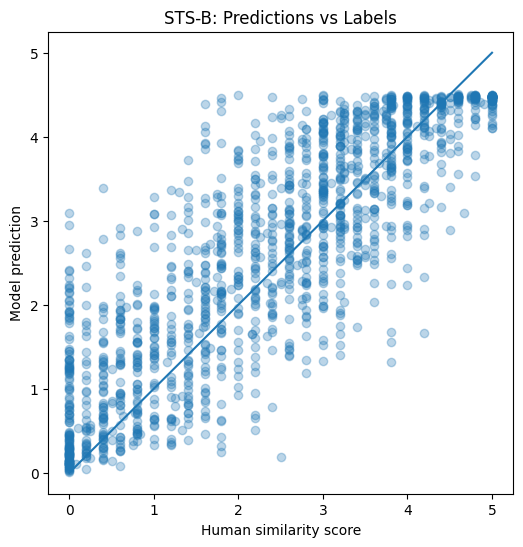

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 6))
plt.scatter(labels, preds, alpha=0.3)
plt.xlabel("Human similarity score")
plt.ylabel("Model prediction")
plt.title("STS-B: Predictions vs Labels")
plt.plot([0, 5], [0, 5])  # ideal diagonal
plt.show()


In [23]:
from datasets import load_dataset

dataset = load_dataset("ag_news")
dataset

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/18.6M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/1.23M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [24]:
dataset["train"][0]

{'text': "Wall St. Bears Claw Back Into the Black (Reuters) Reuters - Short-sellers, Wall Street's dwindling\\band of ultra-cynics, are seeing green again.",
 'label': 2}

In [25]:
documents = dataset["train"]["text"][:1000]
len(documents)

1000